In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(0,rootdir) 
from config import data_path,output_path

In [2]:
data_folder = f"{data_path}\\pixel_accuracy\\3.annotated_data"
markerless_one_folder = f"{data_folder}\\markerless\\one"
markerless_two_folder =  f"{data_folder}\\markerless\\two"
markerbased_one_folder = f"{data_folder}\\markerbased\\one"
marker_based_two_folder = f"{data_folder}\\markerbased\\two"

TIP_CORRECTION_DISTANCE = 7

In [3]:
output_folder = output_path

In [4]:
import cv2
import dill
import numpy as np
import os
from pathlib import Path
from scipy.spatial import distance

In [5]:
def folder_extract(path):
    detected = []
    truths = []
    for name in os.listdir(path):
        if name.endswith(".png"):
            i = Path(name).stem
            with open(f"{path}/{i}.pkl", "rb") as f_d:
                with open(f"{path}/{i}.truth", "rb") as f_t:
                    d = dill.load(f_d)
                    t = dill.load(f_t)
                    detected.append(d)
                    truths.append(t)
    return detected, truths

def closest_point(p, list_of_points):
    """Return closest point to p from a list of points"""
    return list_of_points[closest_point_index(p, list_of_points)]


def closest_point_index(p, list_of_points):
    """Returns index of the point in list_of_point closest to point p"""
    list_of_points = np.asarray(list_of_points)
    deltas = list_of_points - p
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)

def calculate_marker_single_distances(detected,truths):
    distances = []
    for d,t in zip(detected,truths):
        distances.append(distance.euclidean(d,t))
    return distances

def calculate_marker_double_distances(detected,truths):
    distances = []
    for d,t in zip(detected,truths):
        for tp in t:
            closest_detected = closest_point(tp,d)
            distances.append(distance.euclidean(closest_detected,tp))
    return distances
    
def calculate_hand_single_distances(detected,truths):
    distances = []
    for d,t in zip(detected,truths):
        tips = [o["tip"] for o in d]
        closest_index = closest_point_index(t,tips)
        closest_tip = np.asarray(d[closest_index]["tip"])
        closest_palm = np.asarray(d[closest_index]["palm"])
        
        vector = closest_palm - closest_tip 
        vector_norm =  vector / np.sqrt(np.sum(vector**2))
        tip_corrected = closest_tip + (vector_norm*TIP_CORRECTION_DISTANCE)
        
        distances.append(distance.euclidean(tip_corrected,t))
    return distances
        
def calculate_hand_double_distances(detected, truths):
    distances = []
    for d,t in zip (detected, truths):
        for tp in t:
            tips = [o["tip"] for o in d]
            closest_index = closest_point_index(tp,tips)
            closest_tip = np.asarray(d[closest_index]["tip"])
            closest_palm = np.asarray(d[closest_index]["palm"])
            vector = closest_palm - closest_tip 
            vector_norm =  vector / np.sqrt(np.sum(vector**2))
            tip_corrected = closest_tip + (vector_norm*TIP_CORRECTION_DISTANCE)
            distances.append(distance.euclidean(tip_corrected,tp))
    return distances

def stats(line,array):
    print(f"{line}: {np.mean(array)} +- {np.std(array)}")

In [6]:
hand_one_detected, hand_one_truths = folder_extract(markerless_one_folder)
hand_two_detected, hand_two_truths = folder_extract(markerless_two_folder)

marker_one_detected, marker_one_truths = folder_extract(markerbased_one_folder)
marker_two_detected, marker_two_truths = folder_extract(marker_based_two_folder)


In [7]:
marker_one_distances = calculate_marker_single_distances( marker_one_detected, marker_one_truths )
stats("marker_one_distances", marker_one_distances)

hand_one_distances = calculate_hand_single_distances( hand_one_detected, hand_one_truths )
stats("hand_one_distances", hand_one_distances)

marker_two_distances = calculate_marker_double_distances( marker_two_detected, marker_two_truths )
stats("marker_two_distances", marker_two_distances)

hand_two_distances = calculate_hand_double_distances( hand_two_detected, hand_two_truths )
stats("hand_two_distances", hand_two_distances)


marker_one_distances: 1.3050300878658694 +- 0.6029619693077394
hand_one_distances: 2.577868954426835 +- 1.4769605087448965
marker_two_distances: 1.74255432800492 +- 0.8347680799387664
hand_two_distances: 2.9180569526493616 +- 2.1955653392701144


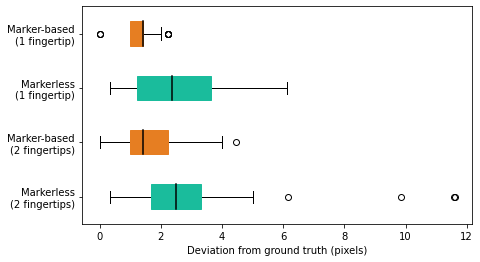

In [8]:
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (7,4)


data = list(reversed([ marker_one_distances, hand_one_distances, marker_two_distances, hand_two_distances  ]))
data_labels = list(reversed(["Marker-based\n(1 fingertip)", "Markerless\n(1 fingertip)", "Marker-based\n(2 fingertips)", "Markerless\n(2 fingertips)"]))

medianprops = dict(linestyle='-', linewidth=1.5, color='black')
fig1, ax1 = plt.subplots()
box = ax1.boxplot(data,notch=False, patch_artist=True,vert=False, medianprops=medianprops)

ax1.set_yticklabels(data_labels)
plt.xlabel("Deviation from ground truth (pixels)")
colors = ['#1ABC9C', '#e67e22', '#1ABC9C', '#e67e22', ]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)

plt.savefig(f"{output_folder}/pixel_accuracy.pdf",bbox_inches='tight', transparent="True", pad_inches=0)
plt.show() 

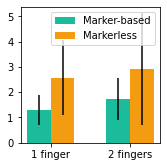

In [9]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (2.5,2.5)
#plt.rcParams["figure.figsize"] = (5,3.5) #xs

df = pandas.DataFrame(dict(graph=['1 finger','2 fingers'],
                           marker=[np.mean(marker_one_distances),np.mean(marker_two_distances)], 
                           hand=[np.mean(hand_one_distances),np.mean(hand_two_distances)])) 

ind = np.arange(len(df))
width = 0.3

fig, ax = plt.subplots()
ax.bar(ind , df.marker, width, 
        color='#1ABC9C', 
        label='Marker-based', 
        yerr=[np.std(marker_one_distances),np.std(marker_two_distances)],
        capsize=0
       )
ax.bar(ind+ width, df.hand, width, color='#f39c12', label='Markerless',  
        yerr=[np.std(hand_one_distances),np.std(hand_two_distances)],
        capsize=0
       )


ax.set(xticks=ind + width/2, xticklabels=df.graph)
ax.legend()
#plt.ylabel("Deviation from ground truth (pixels)")

plt.savefig(f"{output_folder}/pixel_accuracy_xs.pdf",bbox_inches='tight', transparent="True", pad_inches=0)
plt.show() 

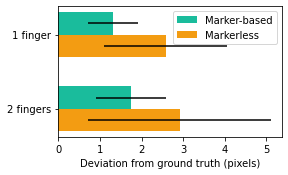

In [10]:
plt.rcParams["figure.figsize"] = (4,2.4)

width = 0.3

fig, ax = plt.subplots()
ax.barh(ind , df.marker, width, 
        color='#1ABC9C', 
        label='Marker-based', 
        xerr=[np.std(marker_one_distances),np.std(marker_two_distances)],
        capsize=0
       )
ax.barh(ind+ width, df.hand, width, color='#f39c12', label='Markerless',  
        xerr=[np.std(hand_one_distances),np.std(hand_two_distances)],
        capsize=0
       )


ax.set(yticks=ind + width/2, yticklabels=df.graph)
ax.legend()
plt.xlabel("Deviation from ground truth (pixels)")
plt.gca().invert_yaxis()

plt.savefig(f"{output_folder}/pixel_accuracy_xs_hoz.pdf",bbox_inches='tight', transparent="True", pad_inches=0)
plt.show() 